In [ ]:
##########################################
# Nikolaos Paraskakis / I.D.: 2018030027 #
# Advanced Topics in Convex Optimization #
##########################################

In [ ]:
########################################################
#            Modern Portfolio Theory                   #
#             Portfolio Optimization                   #
# Using the PyPortfolioOpt and the Efficient Frontier  #
########################################################

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 508 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 557 kB/s 


In [ ]:
# Import needed libraries

from pandas_datareader import data as web
from pandas_datareader import DataReader
import pandas as pd
import numpy as np
from datetime import datetime
import datetime 
import yfinance as yf
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import copy
plt.style.use('fivethirtyeight')

In [ ]:
# Function to plot any graph

def plot_graph(col,title,xlabel,ylabel,df):

    data = []
    
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)
    
    layout = go.Layout(title= title,
                       xaxis=dict(title=xlabel),
                       yaxis=dict(title=ylabel ),
                       width = 690,
                       height = 500,
                       autosize = False)

    fig = go.Figure(data=data, layout=layout)
    
    fig.show()

In [ ]:
# Function to plot any table 

def plot_table(table, index_title = "", title = "" , layout_width = 900):
    
    colorscale = [[0, '#1a88ff'],[.5, '#e6f2ff'],[1, '#ffffff']]
    
    table = ff.create_table(round(table,4),
                            index = True,
                            index_title=index_title,
                            colorscale=colorscale )
    
    table.update_layout(title_text = title)
    
    table.layout.width=layout_width
    
    py.iplot(table)

In [ ]:
# Get the symbols of the assets in the portfolio

# assets = ['META', 'AMZN', 'NFLX', 'GOOG', 'BA', 'V', 'MA', 'NVDA', 'ATXG', 'OKTA', 'AMD', 'LUNA1-USD', 'MDB', 'AI', 'GFAI', 'CPB', 'VXRT', 'DIS', 'MEGL', 'NTNX', 'HRL', 'GRNQ', 'SOXL', 'TRQ', 'NNDM']

assets = ['META', 'AMZN', 'NFLX', 'GOOG', 'BA', 'V', 'MA']

In [ ]:
# Assign equal weights to the assets (initial guess).

numOfAssets = len(assets)
weights = numOfAssets*[1./numOfAssets]

In [ ]:
# Get the stock/portfolio starting date
startDate = (datetime.datetime.today() - datetime.timedelta(days = 365*5)).strftime("%Y-%m-%d")

# Get the stock/portfolio ending date
endDate = datetime.datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Create a dataframe to store the adjusted closing price of the stocks
df = pd.DataFrame()

# Store the adjusted closing price of the stock into the df
for asset in assets:
  df[asset] = yf.download(asset,
                          start = startDate,
                          end = endDate,
                          progress = False)['Adj Close']

#df = yf.download(assets,
                 #start = startDate,
                 #end = endDate)['Adj Close']

my_assets = df

In [ ]:
# Portfolio Adjusted Closing Price History

title = 'Portfolio Adjusted Closing Price History'
xlabel = 'Date'
ylabel = 'Adjusted Closing Price USD ($)'

col = list(my_assets.columns.values)
plot_graph(col,title,xlabel,ylabel,my_assets)

In [ ]:
# Show the daily simple return

daily_returns = my_assets.pct_change().dropna()

daily_returns

,META,AMZN,NFLX,GOOG,BA,V,MA
Date,,,,,,,
2017-11-07,0.000444,0.002240,-0.021186,0.007242,0.007801,0.001519,-0.000800
2017-11-08,-0.003828,0.008645,0.002808,0.006310,-0.002104,0.003390,0.000000
2017-11-09,-0.001448,-0.003310,-0.012930,-0.008261,-0.005489,-0.002934,-0.004534
2017-11-10,-0.004685,-0.003348,-0.009696,-0.003093,-0.007042,-0.002319,0.001675
2017-11-13,0.001737,0.003394,0.015936,-0.002257,0.006019,-0.004290,0.001003
...,...,...,...,...,...,...,...
2022-10-28,0.012865,-0.068042,-0.004109,0.042981,0.029193,0.024720,0.031625
2022-10-31,-0.060887,-0.009380,-0.012985,-0.019880,-0.009246,-0.010414,-0.003915
2022-11-01,0.021898,-0.055154,-0.017576,-0.043947,0.006105,-0.001110,0.015266


In [ ]:
# Visually show the daily returns per asset

title = 'Percentage daily returns per asset'
xlabel = 'Date'
ylabel = 'Percentage daily returns'

col = list(daily_returns.columns.values)
plot_graph(col,title,xlabel,ylabel,daily_returns)

In [ ]:
# Mean daily volatility for each asset

daily_volatility = daily_returns.std()
daily_volatility = pd.DataFrame({'Asset':daily_volatility.index, 'Daily Volatility':daily_volatility.values})
plot_table(daily_volatility)

(-0.2, 0.2)

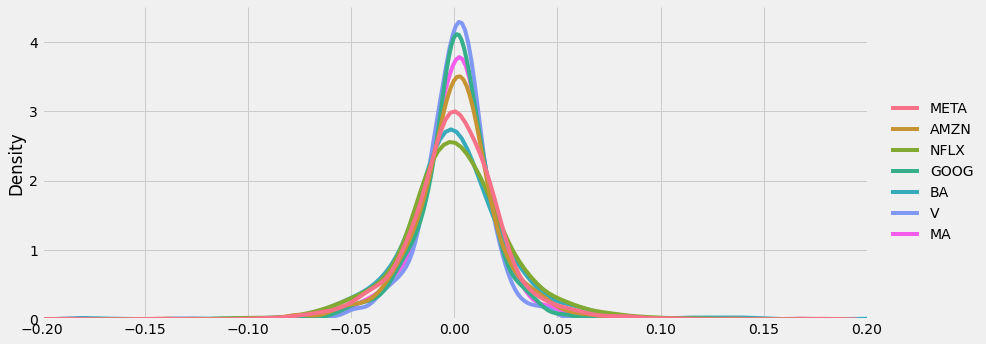

In [ ]:
# Density plot of the daily returns

sns.displot(data = daily_returns, kind = 'kde', aspect = 2.5)
plt.xlim(-0.2,0.2)

In [ ]:
# Annual volatility for each asset

annual_volatility = daily_volatility.loc[:,"Daily Volatility"] * np.sqrt(252)

annual_volatility = pd.DataFrame({'Asset':daily_volatility.loc[:,"Asset"], 'Annual Volatility':annual_volatility.values})

plot_table(annual_volatility)

In [ ]:
# Plot cumulative returns for each asset

daily_cum_returns = 1 + df.dropna().pct_change()
daily_cum_returns = daily_cum_returns.cumprod()*100

title = 'Cumulative returns for each asset'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns.columns.values)
plot_graph(col,title,xlabel,ylabel,daily_cum_returns)

In [ ]:
# Compute correlation matrix between assets

annual_cor_matrix = df.corr().round(3)

# plot_table(corr_df)

fig_corr = px.imshow(annual_cor_matrix, text_auto = True, title = 'Correlation matrix between assets')
fig_corr.show()

In [ ]:
# Compute covariance matrix between assets

annual_cov_matrix = risk_models.sample_cov(df).round(3)

#plot_table(annual_cov_matrix)

fig_cov = px.imshow(annual_cov_matrix, text_auto = True, title = 'Covariance matrix between assets')
fig_cov.show()

In [ ]:
# Compute annual expected returns

annual_mean_returns = expected_returns.mean_historical_return(df)

annual_mean_returns_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Annual Mean Returns':annual_mean_returns.values})

plot_table(annual_mean_returns_df)

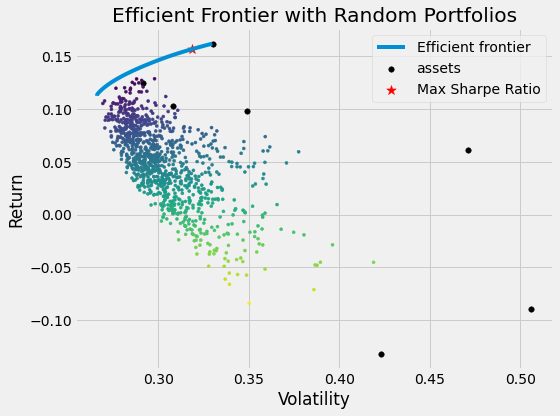

In [ ]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance(risk_free_rate=0)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe Ratio")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(annual_mean_returns, annual_cov_matrix)

In [ ]:
#############################################
# Optimize portfolio for minimum volatility #
#############################################

In [ ]:
ef_1 = EfficientFrontier(annual_mean_returns, annual_cov_matrix)
ef_1.min_volatility()

weights_1 = ef_1.clean_weights()

weights_1_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_1':weights_1.values()})

plot_table(weights_1_df)

In [ ]:
expected_annual_return_1, annual_volatility_1, sharpe_ratio_1 = ef_1.portfolio_performance(risk_free_rate=0)
print('Expected annual return: {}%'.format((expected_annual_return_1*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility_1*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio_1.round(2)))

Expected annual return: 11.26%
Annual volatility: 26.63%
Sharpe ratio: 0.42


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_1 = my_assets.copy(deep=True)
my_assets_1['Optimized Portfolio'] = 0
for asset, weight in weights_1.items():
    my_assets_1['Optimized Portfolio'] += my_assets_1[asset]*weight

my_assets_1

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311218,108.355057,146.081161,85.509663
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263840,108.519623,145.964355,85.630036
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733078,108.887520,145.964355,86.012183
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351242,108.568031,145.302505,85.641294
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588196,108.316307,145.545868,85.391571
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,161.744795
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,159.821231
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,157.450068


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_1[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_1, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'AMZN': 20, 'NFLX': 1, 'GOOG': 32, 'V': 27}
Funds remaining: $15.01


In [ ]:
###############################################
# Optimize portfolio for maximum Sharpe ratio #
###############################################

In [ ]:
ef_2 = EfficientFrontier(annual_mean_returns, annual_cov_matrix)
ef_2.max_sharpe(risk_free_rate=0)

weights_2 = ef_2.clean_weights()

weights_2_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_2':weights_2.values()})

plot_table(weights_2_df)

In [ ]:
expected_annual_return_2, annual_volatility_2, sharpe_ratio_2 = ef_2.portfolio_performance(risk_free_rate=0)
print('Expected annual return: {}%'.format((expected_annual_return_2*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility_2*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio_2.round(2)))

Expected annual return: 15.7%
Annual volatility: 31.89%
Sharpe ratio: 0.49


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_2 = my_assets.copy(deep=True)
my_assets_2['Optimized Portfolio'] = 0
for asset, weight in weights_2.items():
    my_assets_2['Optimized Portfolio'] += my_assets_2[asset]*weight

my_assets_2

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311218,108.355057,146.081161,138.358909
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263840,108.519623,145.964355,138.271233
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733078,108.887520,145.964355,138.306253
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351242,108.568031,145.302505,137.675529
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588196,108.316307,145.545868,137.883679
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,310.264677
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,308.967501
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,313.136619


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_2[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_2, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'AMZN': 5, 'GOOG': 3, 'MA': 30}
Funds remaining: $27.93


In [ ]:
###################################################################
# Optimize portfolio by maximizing return for a given target risk #
###################################################################

In [ ]:
ef_3 = EfficientFrontier(annual_mean_returns, annual_cov_matrix)
ef_3.efficient_risk(0.3)

weights_3 = ef_3.clean_weights()

weights_3_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_3':weights_3.values()})

plot_table(weights_3_df)

In [ ]:
expected_annual_return_3, annual_volatility_3, sharpe_ratio_3 = ef_3.portfolio_performance(risk_free_rate=0)
print('Expected annual return: {}%'.format((expected_annual_return_3*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility_3*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio_3.round(2)))

Expected annual return: 14.63%
Annual volatility: 30.0%
Sharpe ratio: 0.49


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_3 = my_assets.copy(deep=True)
my_assets_3['Optimized Portfolio'] = 0
for asset, weight in weights_3.items():
    my_assets_3['Optimized Portfolio'] += my_assets_3[asset]*weight

my_assets_3

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311218,108.355057,146.081161,122.693233
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263840,108.519623,145.964355,122.677742
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733078,108.887520,145.964355,122.782701
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351242,108.568031,145.302505,122.210716
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588196,108.316307,145.545868,122.339644
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,270.700626
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,269.326195
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,271.833599


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_3[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_3, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'AMZN': 11, 'GOOG': 16, 'V': 1, 'MA': 24}
Funds remaining: $67.03


In [ ]:
###################################################################
# Optimize portfolio by minimizing risk for a given target return #
###################################################################

In [ ]:
ef_4 = EfficientFrontier(annual_mean_returns, annual_cov_matrix)
ef_4.efficient_return(0.15)

weights_4 = ef_4.clean_weights()

weights_4_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_4':weights_4.values()})

plot_table(weights_4_df)

In [ ]:
expected_annual_return_4, annual_volatility_4, sharpe_ratio_4 = ef_4.portfolio_performance(risk_free_rate=0)
print('Expected annual return: {}%'.format((expected_annual_return_4*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility_4*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio_4.round(2)))

Expected annual return: 15.0%
Annual volatility: 30.59%
Sharpe ratio: 0.49


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_4 = my_assets.copy(deep=True)
my_assets_4['Optimized Portfolio'] = 0
for asset, weight in weights_4.items():
    my_assets_4['Optimized Portfolio'] += my_assets_4[asset]*weight

my_assets_4

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311218,108.355057,146.081161,127.718128
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263840,108.519623,145.964355,127.677309
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733078,108.887520,145.964355,127.755232
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351242,108.568031,145.302505,127.159699
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588196,108.316307,145.545868,127.320845
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,283.947804
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,282.612901
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,285.682730


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_4[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_4, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'AMZN': 9, 'GOOG': 13, 'MA': 26}
Funds remaining: $72.51


In [ ]:
############################################
# Optimize portfolio by maximizing utility #
############################################

In [ ]:
ef_5 = EfficientFrontier(annual_mean_returns, annual_cov_matrix)
ef_5.max_quadratic_utility(risk_aversion=1)

weights_5 = ef_5.clean_weights()

weights_5_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_5':weights_5.values()})

plot_table(weights_5_df)

In [ ]:
expected_annual_return_5, annual_volatility_5, sharpe_ratio_5 = ef_5.portfolio_performance(risk_free_rate=0)
print('Expected annual return: {}%'.format((expected_annual_return_5*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility_5*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio_5.round(2)))

Expected annual return: 16.22%
Annual volatility: 33.02%
Sharpe ratio: 0.49


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_5 = my_assets.copy(deep=True)
my_assets_5['Optimized Portfolio'] = 0
for asset, weight in weights_5.items():
    my_assets_5['Optimized Portfolio'] += my_assets_5[asset]*weight

my_assets_5

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311218,108.355057,146.081161,146.081161
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263840,108.519623,145.964355,145.964355
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733078,108.887520,145.964355,145.964355
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351242,108.568031,145.302505,145.302505
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588196,108.316307,145.545868,145.545868
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,329.470001
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,328.179993
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,333.190002


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_5[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_5, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'MA': 32}
Funds remaining: $106.56


In [ ]:
import scipy.io
cm = annual_cov_matrix.to_numpy()
scipy.io.savemat('covMat.mat',dict(x=cm))

In [ ]:
scipy.io.savemat('meanReturns.mat',dict(x=np.array(annual_mean_returns)))